# Part 1 - Flatten, Pooling with various hyperparameter tuning


This is 1st-part in a 3-parts series: build out 7 neural-nets with hyperparameter-tuning, to identify the best machine-learing model for a sarcasm detector.

1. Project sentences into Vector aka Embedding
2. Compare 6 neural-nets, along with hyperparameter tuning to determine the best/7th model: stacked LSTMs
3. Incorporate a pretained 27-billion token, 1.2-million word vocab in 25 dimensions from Twitter crawl of 2 billion Tweets
4. Visualization through Google Projector

## 0. Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. Build "Stopwords"

Just like TF/IDF days, where frequency of words may be inversely related to the importance ... anyone remember LDA, hehe.  

In [2]:
from bs4 import BeautifulSoup
import string

stopwords_list = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

# Create the mapping table to use in translate()
stopwords_table = str.maketrans('', '', string.punctuation)

## 2. Process "sarcasm.json" file 

Sarcasm data provided by Laurency Moroney https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

Data looks like this

In [3]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

print("records total", len(datastore))

records total 26709


### 2.1. Load sentences, cleaning text and exclude "stopwords"

In [4]:
sentences = [] 
labels = []
urls = []

for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(stopwords_table) #replace specified characters with the character described the mapping table
        if word not in stopwords_table:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

### 2.2. Sample data

In [5]:
print("The length of list is: ", len(sentences))

# Show the last N elements
N = 10
print("The last", N, "elements of list are : ", str(sentences[-N:]), "elements of label are : ", str(labels[-N:]))

The length of list is:  26709
The last 10 elements of list are :  ['what you should buy your basic friend  according to pinterest ', 'whats in your mailbox tips on what to do when uncle sam comes knocking ', 'paul ryan is more of a con man than ever ', 'pentagon to withhold budget figures out of respect for american families ', 'pope francis wearing sweater vestments he got for christmas ', 'american politics in moral free  fall ', 'americas best 20 hikes ', 'reparations and obama ', 'israeli ban targeting boycott supporters raises alarm abroad ', 'gourmet gifts for the foodie 2014 '] elements of label are :  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


### 2.3. Train/split

In [6]:
training_size = 23000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

### 2.4. Sentenses into sequences with Tokenizer, Padding and "Out-of-Vocabulary" tokens

In [7]:
vocab_size = 10000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
word_count = tokenizer.word_counts
##print(word_count)
print(len(word_index))

max_length = 100
trunc_type='post'
padding_type='post'

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

24437


### 2.5. Convert to Numpy

In [8]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### 2.6. Helper function for ploting 

In [9]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model 1: Flatten

We begin with a simple Flatten layer. Main advantage is very fast to train. 

Specifically, 
1. 16-dimension (arbitary, will tune)
2. Flatten layer
3. Followed by a dense layer with 24-neuron.
4. Final layer is 1 neuron with sigmoid for binary outcome 
5. Epochs = 30

In [10]:
# Set model-parameters
embedding_dim = 16
dense_dim = 24 # original 6
num_epochs = 30

In [11]:
flatten_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#  input_length: Length of input sequences, when it is constant. 
# Required if connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

flatten_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
flatten_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 24)                38424     
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 198,449
Trainable params: 198,449
Non-trainable params: 0
_________________________________________________________________


In [12]:
flatten_history  = flatten_model.fit(training_padded, training_labels,
                                     epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 4s 5ms/step - loss: 0.4255 - accuracy: 0.7887 - val_loss: 0.3116 - val_accuracy: 0.8676
Epoch 2/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2029 - accuracy: 0.9207 - val_loss: 0.3209 - val_accuracy: 0.8649
Epoch 3/30
719/719 [==============================] - 3s 4ms/step - loss: 0.1035 - accuracy: 0.9664 - val_loss: 0.3825 - val_accuracy: 0.8603
Epoch 4/30
719/719 [==============================] - 3s 4ms/step - loss: 0.0424 - accuracy: 0.9887 - val_loss: 0.4603 - val_accuracy: 0.8601
Epoch 5/30
719/719 [==============================] - 3s 4ms/step - loss: 0.0160 - accuracy: 0.9970 - val_loss: 0.5401 - val_accuracy: 0.8571
Epoch 6/30
719/719 [==============================] - 3s 4ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.5854 - val_accuracy: 0.8576
Epoch 7/30
719/719 [==============================] - 3s 5ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.6457 - val_accuracy: 0.8590
Epoch 

## Result

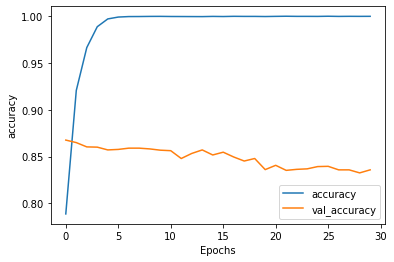

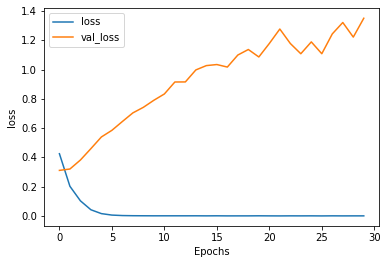

In [13]:
plot_graphs(flatten_history, 'accuracy')
plot_graphs(flatten_history, 'loss')

# Model 2 : Pooling 


In the this section, we will 
1. Stay with 16-dimension (as 16 is arbitary, we will tune in next section)
2. Flatten layer is replaced with pooling and specifically, GlobalAveragePooling1D to average out for a fixed-length vendor

Rest is the same
3. Followed by a dense layer with 24-neuron.
4. Final layer is 1 neuron with sigmoid for binary outcome 
5. Epochs = 30

In [14]:
pooling_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    
pooling_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
pooling_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [15]:
pooling_history = pooling_model.fit(training_padded, training_labels, epochs=num_epochs, 
                              validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
719/719 - 5s - loss: 0.6623 - accuracy: 0.5869 - val_loss: 0.5639 - val_accuracy: 0.7123 - 5s/epoch - 7ms/step
Epoch 2/30
719/719 - 4s - loss: 0.4276 - accuracy: 0.8301 - val_loss: 0.3766 - val_accuracy: 0.8509 - 4s/epoch - 5ms/step
Epoch 3/30
719/719 - 4s - loss: 0.3185 - accuracy: 0.8734 - val_loss: 0.3498 - val_accuracy: 0.8552 - 4s/epoch - 5ms/step
Epoch 4/30
719/719 - 3s - loss: 0.2707 - accuracy: 0.8939 - val_loss: 0.3395 - val_accuracy: 0.8541 - 3s/epoch - 5ms/step
Epoch 5/30
719/719 - 3s - loss: 0.2391 - accuracy: 0.9067 - val_loss: 0.3414 - val_accuracy: 0.8498 - 3s/epoch - 4ms/step
Epoch 6/30
719/719 - 4s - loss: 0.2131 - accuracy: 0.9180 - val_loss: 0.3437 - val_accuracy: 0.8533 - 4s/epoch - 5ms/step
Epoch 7/30
719/719 - 3s - loss: 0.1924 - accuracy: 0.9275 - val_loss: 0.3594 - val_accuracy: 0.8536 - 3s/epoch - 4ms/step
Epoch 8/30
719/719 - 3s - loss: 0.1748 - accuracy: 0.9353 - val_loss: 0.3643 - val_accuracy: 0.8555 - 3s/epoch - 4ms/step
Epoch 9/30
719/719 - 3s 

## Result

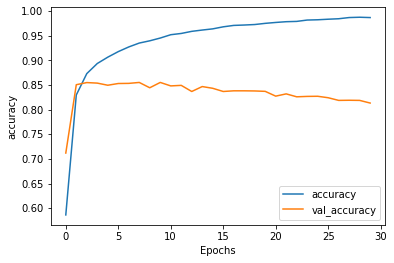

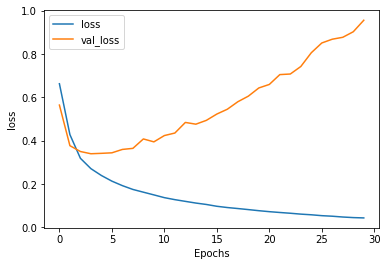

In [16]:
plot_graphs(pooling_history, "accuracy")
plot_graphs(pooling_history, "loss")

### We are overfitting

From the plotting of train/valid accuracy and loss, we see that:
1. Accuracy-curve for train/validation is reasonable, considering validation data may contains many words unseen in training data
2. However, validation vs. training-loss is diverging sharply


# Hyperparameter tuning 

Usually, we should not dive straight to hyperparameter tuning. 

We need EDA (and domain-knowledge if necessary), to surface whether there are other more effective means. For example, in our case, tokenize with different vocabulary size. 

Assuming we have done that, let's move to some mechanisms to reduce overfitting. 

## 1. Learing-rate and optimizer
- Adjust learning rate from Default of 0.001 -> 0.0001
- Beta_1/2 as default 
- Optimzer from Adam -> Adam + gradient descent 
- Epochs from 30 -> 100

In [17]:
num_epochs = 100

tuning_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False) 
tuning_model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

tuning_model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [18]:
tuning_history = tuning_model.fit(training_padded, training_labels, epochs=num_epochs, 
                              validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/100
719/719 - 4s - loss: 0.6880 - accuracy: 0.5596 - val_loss: 0.6833 - val_accuracy: 0.5700 - 4s/epoch - 5ms/step
Epoch 2/100
719/719 - 3s - loss: 0.6845 - accuracy: 0.5596 - val_loss: 0.6814 - val_accuracy: 0.5700 - 3s/epoch - 4ms/step
Epoch 3/100
719/719 - 3s - loss: 0.6825 - accuracy: 0.5596 - val_loss: 0.6787 - val_accuracy: 0.5700 - 3s/epoch - 4ms/step
Epoch 4/100
719/719 - 3s - loss: 0.6790 - accuracy: 0.5596 - val_loss: 0.6741 - val_accuracy: 0.5700 - 3s/epoch - 4ms/step
Epoch 5/100
719/719 - 3s - loss: 0.6721 - accuracy: 0.5596 - val_loss: 0.6657 - val_accuracy: 0.5700 - 3s/epoch - 3ms/step
Epoch 6/100
719/719 - 3s - loss: 0.6604 - accuracy: 0.5613 - val_loss: 0.6521 - val_accuracy: 0.5840 - 3s/epoch - 3ms/step
Epoch 7/100
719/719 - 2s - loss: 0.6426 - accuracy: 0.5953 - val_loss: 0.6320 - val_accuracy: 0.6260 - 2s/epoch - 3ms/step
Epoch 8/100
719/719 - 3s - loss: 0.6186 - accuracy: 0.6684 - val_loss: 0.6071 - val_accuracy: 0.7013 - 3s/epoch - 4ms/step
Epoch 9/100
719/

Epoch 68/100
719/719 - 2s - loss: 0.1543 - accuracy: 0.9444 - val_loss: 0.3638 - val_accuracy: 0.8585 - 2s/epoch - 3ms/step
Epoch 69/100
719/719 - 2s - loss: 0.1522 - accuracy: 0.9452 - val_loss: 0.3654 - val_accuracy: 0.8598 - 2s/epoch - 3ms/step
Epoch 70/100
719/719 - 3s - loss: 0.1503 - accuracy: 0.9464 - val_loss: 0.3674 - val_accuracy: 0.8606 - 3s/epoch - 4ms/step
Epoch 71/100
719/719 - 3s - loss: 0.1484 - accuracy: 0.9472 - val_loss: 0.3696 - val_accuracy: 0.8590 - 3s/epoch - 4ms/step
Epoch 72/100
719/719 - 3s - loss: 0.1468 - accuracy: 0.9481 - val_loss: 0.3718 - val_accuracy: 0.8593 - 3s/epoch - 4ms/step
Epoch 73/100
719/719 - 2s - loss: 0.1449 - accuracy: 0.9492 - val_loss: 0.3742 - val_accuracy: 0.8568 - 2s/epoch - 3ms/step
Epoch 74/100
719/719 - 2s - loss: 0.1431 - accuracy: 0.9494 - val_loss: 0.3764 - val_accuracy: 0.8579 - 2s/epoch - 3ms/step
Epoch 75/100
719/719 - 2s - loss: 0.1417 - accuracy: 0.9509 - val_loss: 0.3788 - val_accuracy: 0.8560 - 2s/epoch - 3ms/step
Epoch 76

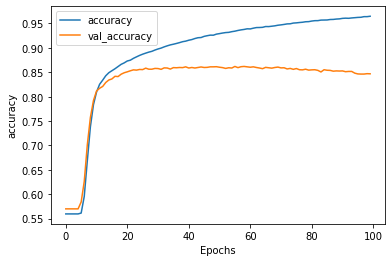

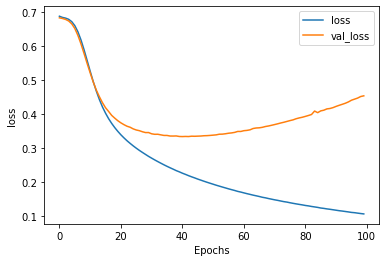

In [19]:
plot_graphs(tuning_history, "accuracy")
plot_graphs(tuning_history, "loss")

Validation-loss is less divergent than before.


## 2. Dimension - initially at 16, to 4th-root

In [20]:
embedding_dim = 10 ## 4th-root of 10,000 = 10
num_epochs = 100

tuning_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

tuning_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

tuning_model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 global_average_pooling1d_2   (None, 10)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                264       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 100,289
Trainable params: 100,289
Non-trainable params: 0
_________________________________________________________________


In [21]:
tuning_history = tuning_model.fit(training_padded, training_labels, epochs=num_epochs, 
                              validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/100
719/719 - 4s - loss: 0.6725 - accuracy: 0.5618 - val_loss: 0.6169 - val_accuracy: 0.6522 - 4s/epoch - 5ms/step
Epoch 2/100
719/719 - 4s - loss: 0.5107 - accuracy: 0.7777 - val_loss: 0.4480 - val_accuracy: 0.8474 - 4s/epoch - 5ms/step
Epoch 3/100
719/719 - 2s - loss: 0.3866 - accuracy: 0.8714 - val_loss: 0.3927 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 4/100
719/719 - 3s - loss: 0.3194 - accuracy: 0.8924 - val_loss: 0.3639 - val_accuracy: 0.8590 - 3s/epoch - 3ms/step
Epoch 5/100
719/719 - 2s - loss: 0.2728 - accuracy: 0.9083 - val_loss: 0.3675 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 6/100
719/719 - 2s - loss: 0.2387 - accuracy: 0.9206 - val_loss: 0.3530 - val_accuracy: 0.8590 - 2s/epoch - 3ms/step
Epoch 7/100
719/719 - 2s - loss: 0.2123 - accuracy: 0.9286 - val_loss: 0.3601 - val_accuracy: 0.8582 - 2s/epoch - 2ms/step
Epoch 8/100
719/719 - 2s - loss: 0.1917 - accuracy: 0.9359 - val_loss: 0.3922 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 9/100
719/

Epoch 68/100
719/719 - 3s - loss: 0.0075 - accuracy: 0.9981 - val_loss: 2.3943 - val_accuracy: 0.7902 - 3s/epoch - 4ms/step
Epoch 69/100
719/719 - 2s - loss: 0.0123 - accuracy: 0.9969 - val_loss: 2.3621 - val_accuracy: 0.7905 - 2s/epoch - 3ms/step
Epoch 70/100
719/719 - 2s - loss: 0.0081 - accuracy: 0.9980 - val_loss: 2.5751 - val_accuracy: 0.7994 - 2s/epoch - 3ms/step
Epoch 71/100
719/719 - 2s - loss: 0.0069 - accuracy: 0.9985 - val_loss: 2.5915 - val_accuracy: 0.7954 - 2s/epoch - 3ms/step
Epoch 72/100
719/719 - 2s - loss: 0.0052 - accuracy: 0.9988 - val_loss: 2.6282 - val_accuracy: 0.7951 - 2s/epoch - 3ms/step
Epoch 73/100
719/719 - 2s - loss: 0.0052 - accuracy: 0.9989 - val_loss: 2.6474 - val_accuracy: 0.7959 - 2s/epoch - 3ms/step
Epoch 74/100
719/719 - 2s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 2.7027 - val_accuracy: 0.7916 - 2s/epoch - 2ms/step
Epoch 75/100
719/719 - 2s - loss: 0.0045 - accuracy: 0.9990 - val_loss: 2.5619 - val_accuracy: 0.7832 - 2s/epoch - 3ms/step
Epoch 76

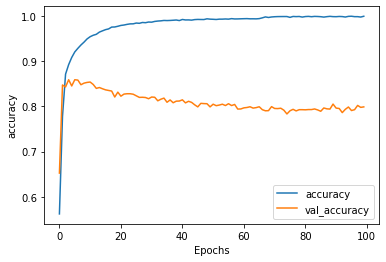

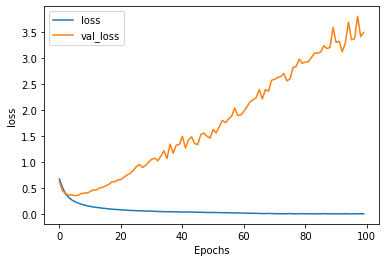

In [22]:
plot_graphs(tuning_history, "accuracy")
plot_graphs(tuning_history, "loss")

### Looks like we are heading down the wrong direction!

Try something else...

## 3. Dropout and Regularization (L2)

Note: we are throwing dropout and regularization together below (usually one at a time)

In [23]:
embedding_dim = 10 ## 4th-root of 10,000 = 10
num_epochs = 30

tuning_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu',
                         kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

tuning_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

tuning_model.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 10)          100000    
                                                                 
 global_average_pooling1d_3   (None, 10)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 24)                264       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 100,289
Trainable params: 100,289
Non-trainable params: 0
________________________________________________

In [24]:
tuning_history = tuning_model.fit(training_padded, training_labels, epochs=num_epochs, 
                              validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
719/719 - 4s - loss: 0.7102 - accuracy: 0.5588 - val_loss: 0.6832 - val_accuracy: 0.5700 - 4s/epoch - 5ms/step
Epoch 2/30
719/719 - 2s - loss: 0.6836 - accuracy: 0.5596 - val_loss: 0.6738 - val_accuracy: 0.5700 - 2s/epoch - 3ms/step
Epoch 3/30
719/719 - 2s - loss: 0.6355 - accuracy: 0.6568 - val_loss: 0.5784 - val_accuracy: 0.7687 - 2s/epoch - 3ms/step
Epoch 4/30
719/719 - 2s - loss: 0.5383 - accuracy: 0.8025 - val_loss: 0.5087 - val_accuracy: 0.8345 - 2s/epoch - 3ms/step
Epoch 5/30
719/719 - 2s - loss: 0.4810 - accuracy: 0.8326 - val_loss: 0.4684 - val_accuracy: 0.8361 - 2s/epoch - 3ms/step
Epoch 6/30
719/719 - 2s - loss: 0.4436 - accuracy: 0.8483 - val_loss: 0.4447 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 7/30
719/719 - 2s - loss: 0.4117 - accuracy: 0.8650 - val_loss: 0.4258 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 8/30
719/719 - 3s - loss: 0.3878 - accuracy: 0.8754 - val_loss: 0.4152 - val_accuracy: 0.8539 - 3s/epoch - 4ms/step
Epoch 9/30
719/719 - 2s 

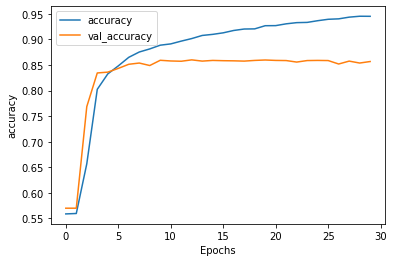

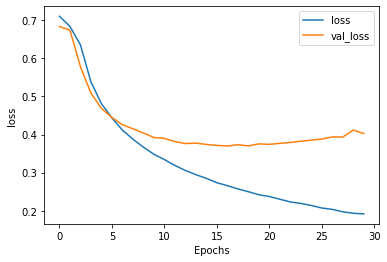

In [25]:
plot_graphs(tuning_history, "accuracy")
plot_graphs(tuning_history, "loss")

# Testing

In [26]:
test_sentences = [
    "Football season finale showing this sunday night"
    "It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
    "It's a beautiful sunny day",
    "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
    "granny starting to fear spiders in the garden might be real",
    "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

sequences = tokenizer.texts_to_sequences(test_sentences)
#print(sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(padded)

predictions = tuning_model.predict(padded)
print("1 is sacarsm, 0 is not")
print(predictions)

1 is sacarsm, 0 is not
[[0.01832026]
 [0.23153561]
 [0.00725162]
 [0.48445904]
 [0.9677321 ]]


# Not bad?